### The code builds a simple two-step agent using LangGraph to:
1. Search the web for information about a topic.

2. Generate a blog post in a specific format using an LLM (OpenAI Chat model), with a small state machine controlling the flow.

### High-Level Overview
- **Purpose:** Given a topic (query) and a blog post template (specific_format), the workflow:

1. Uses Tavily (a search API) to gather relevant content.

2. Prompts an OpenAI chat model to write a blog post conforming to the specified format, using the search results as source material.

- **Tech stack:**

1. LangGraph: to build a small state machine (graph) that routes between “search” and “create_blog_post”.

2. Tavily: web search tool to get content for the blog.

3. OpenAI (via langchain_openai): LLM to write the blog post.

3. IPython display: to render a graph diagram and final blog post in a notebook.


## Imports

In [ ]:
from tavily import TavilyClient # Tool Search
from typing_extensions import TypedDict 
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition
from langchain_openai import ChatOpenAI
from IPython.display import Image, display, Markdown
from langchain_core.messages import HumanMessage, SystemMessage

- `TavilyClient:` client to access Tavily’s search API.

- `TypedDict:` for defining a strongly-typed state dictionary.

- `StateGraph, START, END:` LangGraph primitives to define nodes, edges, and graph flow.

- `tools_condition:` imported but not used in this snippet (can be removed).

- `ChatOpenAI:` LangChain wrapper for OpenAI Chat models.

- `Image, display, Markdown:` for visualizing the graph and showing the final output in notebooks.

- `HumanMessage, SystemMessage:` message types for LLM prompts.

## State Definition

In [2]:
class State(TypedDict):
    query: str
    specific_format: str
    search_results: str
    blog_post: str

The agent passes data around in a State dict with four fields:
- `query:` the topic to write about.

- `specific_format:` the blog post template to follow.

- `search_results:` aggregated text from Tavily search.

- `blog_post:` the final LLM-generated post.

## Search Tool Node

In [ ]:
def SearchTool(state: State) -> State:
    tavily_client = TavilyClient(api_key="tvly-dev-***")
    response = tavily_client.search(state["query"])
    if {"url","content"}.issubset(response):
        docs = [response]
    else:
        docs = response.get("results", [])
    state["search_results"] = "\n\n---\n\n".join(
        [f'<Document URL="{d.get("url","")}"/>\n{d.get("content","")}\n</Document>' for d in docs]
    )
    return state

What it does:

- Calls Tavily with the query.

- Normalizes the response into a list of `“docs”`.

- Builds a single string `search_results` by joining all docs with separators.

- Stores that text back into the state.

**Notes:**

- The format includes a simple pseudo-XML wrapper per document for clarity.

## Blog Post Generation Node

In [ ]:
def CreateBlogPost(state: State) -> State:
    llm = ChatOpenAI(model="gpt-4o-mini", api_key="sk-proj-***")
    
    system = SystemMessage(content=
        (
        "You are a helpful assistant who can create a blog post according to a user-specified format (template)."
        "The information required to write this blog post is provided to you by a search tool, and you have to write the blog post based on these results."
        "In date of writing the blog (Date), Enter the date of today"
        )
    )
    user = HumanMessage(content=
        (
        f"Create a blog post about {state['query']} topic."
        f"Using the following format for an example of what I need: {state['specific_format']}."
        f"Use relevant following search results: {state['search_results']}"
        )
    )

    response = llm.invoke([system, user])

    state["blog_post"] = response.content
    return state

What it does:

- Initializes an OpenAI chat model (gpt-4o-mini here).
- Crafts a system message (role/instructions) and a user message (task details).
- Injects both the format template (`specific_format`) and the search results (`search_results`) into the prompt.
- Invokes the model and saves the generated content into `blog_post`.

- **Notes:**

- The prompt explicitly asks the model to follow the template.

## Routing Logic (Supervisor)

In [20]:
# Define routing logic
def supervisor_route(state):
    # Check if we have search results
    if "search_results" in state and state["search_results"]:
        return "create_blog_post"
    else:
        return "search"


What it does:
- Checks whether `search_results` already exist in the state.

- If not present, routes to the `“search”` node; otherwise, routes to `“create_blog_post”`.

- This is a simple, deterministic controller: search first, then write.


## Building the Graph

In [21]:
graph = StateGraph(State)

graph.add_node("create_blog_post", CreateBlogPost)
graph.add_node("search", SearchTool)

graph.add_edge(START, "search")
graph.add_conditional_edges("search", supervisor_route, ["create_blog_post"])
graph.add_edge("create_blog_post", END)

workflow = graph.compile()

What it does:
- Creates a `StateGraph` with two nodes, `search` and `create_blog_post`.

- Flow:

    - START → search

    - From search → conditional edge:

        - If results exist, go to create_blog_post.

    - create_blog_post → END
    
- Compiles the graph into an executable `workflow`.


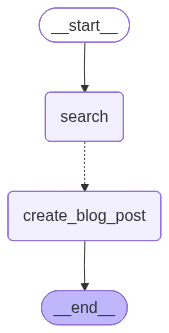

In [22]:
display(Image(workflow.get_graph().draw_mermaid_png()))

Renders a diagram of the graph (requires a notebook environment and Graphviz/Mermaid rendering support via LangGraph).

## Template for the Blog Post

In [ ]:
format_sample_blog_post ="""
Target audience (e.g., developers, marketers, beginners, executives)? developers
Tone (e.g., friendly, authoritative, academic, playful)? authoritative
Typical length (e.g., 800–1,500 words)? 900-1200
SEO needs (keywords, meta description)?
Visuals (images, code snippets, diagrams)? code and table

Default blog post template (tech/AI audience)
1) Front matter
Title:
Subtitle:
Author: Emjey
Date: 
Reading time:
Category/Tags:
Target keyword:
Meta description (150–160 chars):

2) Hook
1–3 punchy sentences that state the problem and promise the outcome.
Optional stat or question to build curiosity.
3) Summary 
 3–5 bullets with the key takeaways.
 Who this post is for.
 What readers will be able to do after reading.
4) Context and problem framing
What’s changing in the space and why this matters now.
Define the problem clearly (pain points, constraints, stakes).
Scope: what’s included/excluded.
5) Core concepts
Definitions of key terms (concise, scannable).
Mental model or analogy to anchor understanding.
6) Step-by-step walkthrough
Step title — goal and prerequisites.
Step title — clear actions, code/commands if relevant.
Step title — validation checks and expected outputs.
Include:
Code blocks (copy-paste ready).
Notes, pitfalls, and alternatives.
7) Example (end-to-end)
Brief scenario.
Input → Process → Output.
Why this approach works and trade-offs.
8) Visuals and artifacts
 Diagram or architecture sketch.
 Table summarizing options/parameters.
 Links to a GitHub repo, Colab, or demo.
9) Performance, costs, and trade-offs
When it shines vs. when it struggles.
Benchmarks or back-of-the-envelope math.
Security/privacy considerations.
10) Conclusion and next steps
Recap the benefit in one sentence.
What to try next (related posts, advanced guides).
Clear CTA.
11) FAQs
3–6 focused Q&As addressing common objections.
12) References
Standards, docs, research, and high-quality articles.
"""

This multiline string defines the desired blog format (template) and some preferences, which the LLM will attempt to follow.

## Running the Workflow

In [24]:
response = workflow.invoke({"query": "GPT-5 Prompt Migration and Improvement Using the New Optimizer | OpenAI Cookbook", "specific_format": format_sample_blog_post})
display(Markdown(response["blog_post"]))

---
**Front matter**  
**Title:** GPT-5 Prompt Migration and Improvement Using the New Optimizer  
**Subtitle:** Harnessing the New Tools for Effective GPT-5 Prompt Management  
**Author:** Emjey Fakhraei  
**Date:** October 15, 2023  
**Reading time:** 10 minutes  
**Category/Tags:** AI, Machine Learning, OpenAI, GPT-5, Prompt Engineering  
**Target keyword:** GPT-5 prompt optimization  
**Meta description (150–160 chars):** Discover how to effectively migrate and improve your prompts for GPT-5 using OpenAI's new Prompt Optimizer tool for better outcomes.  

---

### Hook
The introduction of GPT-5 brings new possibilities for developers aiming to harness its capabilities, but migrating existing prompts can be a daunting task. Enter the Prompt Optimizer—a game-changing tool that simplifies the process of prompt enhancement, allowing for a more effective and seamless integration with GPT-5's new functionalities. Are you ready to elevate your prompt engineering skills?

### Summary
- Explore the importance of migrating prompts to GPT-5.
- Learn how to use the Prompt Optimizer tool effectively.
- Understand the core concepts that underlie prompt engineering for GPT-5.
- Get actionable steps for prompt migration with real-world examples.

**Who this post is for:** Developers working with AI models, particularly those utilizing OpenAI's models.

**What readers will be able to do after reading:** Develop a deeper understanding of prompt optimization and confidently migrate and improve their prompts for GPT-5 using the Prompt Optimizer.

### Context and Problem Framing
As AI continues to evolve, developers are compelled to adapt their approaches to harness the full potential of new models like GPT-5. The introduction of the Prompt Optimizer addresses the complexity and necessity of migrating existing prompts designed for earlier versions, which may not yield optimal results with the latest iteration. 

**Pain points:** 
- Existing prompts may fail to leverage GPT-5's advanced capabilities.
- Developers might struggle with crafting effective prompts under new guidelines.
  
**Scope:** This guide focuses on using the Prompt Optimizer to enhance prompts for GPT-5, excluding other model interactions.

### Core Concepts
**Key Definitions:**
- **Prompt Optimization:** Adjusting the input provided to AI for improved responses.
- **Prompt Migration:** Adapting existing prompts for compatibility with a new AI model.

**Mental Model:** Consider prompts as an engine—the more efficiently you tune the engine, the better performance you can expect.

### Step-by-Step Walkthrough
#### Step 1 — Set up the Prompt Optimizer
**Goal:** Access the newly designed Prompt Optimizer in the OpenAI Playground.

**Prerequisites:** 
- An OpenAI account.
- Access to the Playground.

**Actions:**
1. Log into your OpenAI account.
2. Navigate to the Playground.
3. Select the Prompt Optimizer tool option from the menu.

#### Step 2 — Input Existing Prompts
**Actions:** 
- Copy your existing prompts into the input field.
- Click on the "Optimize" button.

**Expected Output:** A revised prompt optimized for GPT-5's features.

```python
# Example of input prompt
"Write a Python function that calculates the factorial of a number."
```

#### Step 3 — Validate Output
**Actions:**
- Test the output by entering it into a new API call setup within the Playground.

**Expected Output:** Check for improved relevance and creativity in the generated text.

### Example (End-to-End)
**Scenario:** You have a prompt that asks for a guide on AI ethics.

**Input:** "Explain the importance of AI ethics."

**Process:** After optimization, the revised prompt includes suggestions for discussing real-world applications and ethical considerations.

**Output:** A comprehensive and nuanced response, highlighting key scenarios in AI ethics.

**Why this approach works:** By using the Prompt Optimizer, developers can ensure that prompts facilitate better understanding and more engaging outputs, thereby maximizing the value derived from GPT-5.

### Visuals and Artifacts
- **Diagram** illustrating the migration process with the Prompt Optimizer.
- **Table** summarizing different parameters for prompt input and expected outputs.

**Links:** 
- [OpenAI Cookbook: Prompt Optimization Guide](https://cookbook.openai.com/examples/gpt-5/prompt-optimization-cookbook/)
- [GitHub Repository for Example Prompts](#)

### Performance, Costs, and Trade-offs
**When it shines:** The Prompt Optimizer excels in ensuring compatibility and enhancing the complexity of interactions, which historically have been challenging for developers.

**When it struggles:** The tool may face limitations with highly specialized or unique prompts that require nuanced human insight beyond the model's training data.

**Security/privacy considerations:** Ensure sensitive data is not inadvertently included in prompt inputs, following best practices for data handling.

### Conclusion and Next Steps
Migrating and improving prompts for GPT-5 using the new Prompt Optimizer can substantially enhance your AI applications. 

**What to try next:** Explore advanced guides on prompt engineering strategies and case studies demonstrating real-world applications.

**Clear CTA:** Dive into the OpenAI Cookbook and start utilizing the Prompt Optimizer today to elevate your prompt effectiveness!

### FAQs
**Q: How does the Prompt Optimizer differ from previous methods?**  
A: It simplifies the process of adapting existing prompts for GPT-5's architecture, incorporating new best practices automatically. 

**Q: Can the Optimizer handle complex prompts?**  
A: Yes, but ensure that complex requirements are clearly defined to receive optimal results.

**Q: Is there a cost associated with using the Prompt Optimizer?**  
A: No, accessing the Prompt Optimizer in the Playground is free, subject to the usage limits of your OpenAI account.

### References
- [OpenAI Cookbook: Prompt Optimization](https://cookbook.openai.com/examples/gpt-5/prompt-optimization-cookbook/)
- [GPT-5 Prompting Guide](https://community.openai.com/t/prompting-gpt-5-is-different/1344710)  
- [YouTube Introduction to Prompt Optimizer](https://www.youtube.com/watch?v=emldkKKIpl8)  

---






- What it does:

    - Invokes the compiled graph with:

        - `query:` the topic to search and write about.

        - `specific_format:` the blog post template.

    - The graph:
    
        - Runs the `search` node → fetches search results via Tavily.

        - Routes to `create_blog_post` → asks the LLM to write a post using the template and search results.

    - Displays the final blog post as Markdown.


**Execution Flow Summary**

1. Start with an initial `State` containing `query` and `specific_format`.

2. SearchTool:

    - Queries Tavily and writes combined results to `search_results`.

3. Supervisor:

    - Sees `search_results` is now present; routes to `create_blog_post`.

4. CreateBlogPost:

    - Prompts the LLM with system+user messages including template and search results.

    - Writes `blog_post` back to state.

5. Workflow ends; the blog post is displayed.


**What You Can Customize (*GPT Suggestion*)**
- **The blog template (`specific_format`):** change structure, tone, SEO requirements.

- **The search step:** add filtering, deduplication, or summarization of results.

- **The LLM model:** pick a different OpenAI model or a different provider.

- **The routing:** add more nodes (e.g., “summarize results,” “outline first,” “revise for SEO”) and more conditional logic.
